In [29]:
import os
import pandas as pd

# Import CT image processing functions from pyCoreRelator
from pyCoreRelator import (
    display_slice_bt_std,
    process_and_stitch_segments
)

## All CT image processing functions are from the `pyCoreRelator.log.ct_image2log` module

## Functions

### Data Loading Functions
- `load_dicom_files`: Loads DICOM files from a directory, sorts by z-coordinate, extracts pixel spacing and slice thickness
- `get_slice`: Extracts 2D slice from 3D volume along specified axis (0, 1, or 2)
- `trim_slice`: Removes empty regions from CT slices based on intensity threshold

### Brightness Analysis Functions  
- `get_brightness_trace`: Calculates mean brightness along specified axis
- `get_brightness_stats`: Calculates brightness statistics within central strip of defined width percentages
- `process_brightness_data`: Processes CT slices with trimming and masking of low-brightness regions with buffer zones

### Visualization Functions
- `display_slice`: Shows single slice with optional physical dimensions
- `display_slice_bt_std`: Creates comprehensive 3-panel plots showing:
  - CT image with colormap (left panel)
  - Brightness trace with standard deviation shading (middle panel) 
  - Standard deviation profile (right panel)
  - Supports saving as PNG, SVG, and compressed TIFF formats

### Curve Matching and Stitching Functions
- `find_best_overlap`: Advanced correlation algorithm using:
  - Pearson correlation coefficient calculation
  - Peak/valley matching with weighted scoring:
    - First peaks: weight 2.0
    - First valleys: weight 1.2  
    - Major peaks: weight 0.5
    - Major valleys: weight 0.3
- `stitch_curves`: Intelligent curve alignment with brightness shift correction and overlap averaging
- `plot_stitched_curves`: Comprehensive visualization of stitching results
- `create_stitched_slice`: Creates composite CT slice from overlapping segments

### Automated Processing Functions
- `process_single_scan`: Complete workflow for processing single CT scans
- `process_two_scans`: Processes and stitches two scans with optimized overlap detection
- `process_and_stitch_segments`: Handles complex core structures supporting:
  - Single and multiple scans per segment
  - A/B/C suffix support for sub-segments
  - Automatic rescaling to RGB image dimensions with interpolation
  - Upside-down core rotation capability

# **Functions for Curve Matching and Stitching**

The following functions handle matching and stitching of CT scan brightness curves:

### Overlap Detection
- `find_best_overlap`: Finds optimal overlap between two curves by maximizing:
  1. Pearson correlation coefficient ($r$) between overlapping sections:
     $$r = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum(x_i - \bar{x})^2\sum(y_i - \bar{y})^2}}$$
  2. Peak matching score based on prominence alignment
     Final score: $score = r + \sum_{peaks} w_p$ where $w_p = 2.0$ per matched peak pair

### Curve Stitching  
- `stitch_curves`: Combines overlapping curves by:
  1. Finding optimal overlap position
  2. Averaging overlap region values: $v_{overlap} = \frac{v_1 + v_2}{2}$
  3. Concatenating sections: $v_{stitched} = [v_1[:-o], v_{overlap}, v_2[o:]]$
     where $o$ is overlap length

### Visualization
- `plot_stitched_curves`: Displays stitching results with:
  - Original curves and overlap regions
  - Final stitched curve
  - Stitch point markers
  - Brightness and standard deviation plots


<hr>

### Define core CT data

In [30]:
# # Define core information
# cruise_name = "M9907"
# core_name = "22PC"
# total_length_cm = 501  # Adjust this value based on actual core length
# width_start_pct=0.25
# width_end_pct=0.75

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders. Order means from top to bottom
# core_structure = {
#     f'{cruise_name}-{core_name}-4': {
#         'scans': ['SE000000'],
#         'params': {
#             'SE000000': {'trim_top': 820, 'trim_bottom': 15, 'min_brightness': 400, 'buffer': 5}   #without cut off the T1 T2, trim_top = 30
#         },
#         'rgb_pxlength': 4555, 'rgb_pxwidth': 995,
#         'upside_down': False   #True if the CT image is upside down
#     },
#     f'{cruise_name}-{core_name}-3': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 55, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 10},
#             'SE000002': {'trim_top': 20, 'trim_bottom': 55, 'min_brightness': 400, 'buffer': 10}
#         },
#         'rgb_pxlength': 15050, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-2': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 55, 'trim_bottom': 110, 'min_brightness': 400, 'buffer': 10},
#             'SE000002': {'trim_top': 120, 'trim_bottom': 40, 'min_brightness': 400, 'buffer': 10}
#         },
#         'rgb_pxlength': 14970, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-1': {
#         'suffixes': ['A', 'B', 'C'],
#         'scans': ['SE000000'],
#         'params': {
#             'A/SE000000': {'trim_top': 45, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 5},
#             'B/SE000000': {'trim_top': 1, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 5},
#             'C/SE000000': {'trim_top': 1, 'trim_bottom': 35, 'min_brightness': 400, 'buffer': 5}
#         },
#         'rgb_pxlength': 14890, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }
# }


In [31]:
# # Define core information
# cruise_name = "M9907"
# core_name = "23PC"
# total_length_cm = 783  # Adjust this value based on actual core length
# width_start_pct=0.25
# width_end_pct=0.75

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders for M9907-23PC
# core_structure = {
#     f'{cruise_name}-{core_name}-6': {
#         'scans': ['SE000000'], #without cut off the T0
#         # 'scans': ['SE000000', 'SE000002'], #to cut off the T0
#         'params': {
#             # 'SE000000': {'trim_top': 60, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 5}, #without cut off the T0
#             # 'SE000002': {'trim_top': 5, 'trim_bottom': 60, 'min_brightness': 400, 'buffer': 5}  #without cut off the T0
#             'SE000000': {'trim_top': 62, 'trim_bottom': 532, 'min_brightness': 400, 'buffer': 5}   #to cut off the T0
#         },
#         'rgb_pxlength': 6305, 'rgb_pxwidth': 995,
#         'upside_down': True
#     },
#     f'{cruise_name}-{core_name}-5': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 50, 'trim_bottom': 190, 'min_brightness': 400, 'buffer': 5},
#             'SE000002': {'trim_top': 150, 'trim_bottom': 50, 'min_brightness': 400, 'buffer': 5}
#         },
#         'rgb_pxlength': 14965, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-4': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 50, 'trim_bottom': 150, 'min_brightness': 400, 'buffer': 5},
#             'SE000002': {'trim_top': 170, 'trim_bottom': 50, 'min_brightness': 400, 'buffer': 5}
#         },
#         'rgb_pxlength': 14945, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-3': {
#         'suffixes': ['A', 'B', 'C'],
#         'scans': ['SE000000'],
#         'params': {
#             'A/SE000000': {'trim_top': 50, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 5},
#             'B/SE000000': {'trim_top': 20, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 5},
#             'C/SE000000': {'trim_top': 1, 'trim_bottom': 40, 'min_brightness': 400, 'buffer': 5}
#         },
#         'rgb_pxlength': 14890, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-2': {
#         'suffixes': ['A', 'B', 'C'],
#         'scans': ['SE000000'],
#         'params': {
#             'A/SE000000': {'trim_top': 45, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 5},
#             'B/SE000000': {'trim_top': 1, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 5},
#             'C/SE000000': {'trim_top': 20, 'trim_bottom': 70, 'min_brightness': 400, 'buffer': 5}
#         },
#         'rgb_pxlength': 11185, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 65, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 5},
#             'SE000002': {'trim_top': 20, 'trim_bottom': 45, 'min_brightness': 400, 'buffer': 5}
#         },
#         'rgb_pxlength': 14915, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }
# }


### M9907-25PC CT data auto-stitiching

In [32]:
# # Define core information
# cruise_name = "M9907"
# core_name = "25PC"
# total_length_cm = 797  # Adjust this value based on actual core length
# width_start_pct=0.25
# width_end_pct=0.75

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders
# core_structure = {
#     f'{cruise_name}-{core_name}-6': {
#         # 'scans': ['SE000000', 'SE000002'], 
#         'scans': ['SE000002'], 
#         'params': {
#             # 'SE000000': {'trim_top': 60, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 50}, 
#             'SE000002': {'trim_top': 122, 'trim_bottom': 42, 'min_brightness': 400, 'buffer': 3}  
#         },
#         'rgb_pxlength': 7635, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-5': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 60, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 3},
#             'SE000002': {'trim_top': 20, 'trim_bottom': 60, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 14958, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-4': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 40, 'trim_bottom': 180, 'min_brightness': 400, 'buffer': 3},
#             'SE000002': {'trim_top': 20, 'trim_bottom': 45, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 14955, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-3': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 50, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 3},
#             'SE000002': {'trim_top': 320, 'trim_bottom': 50, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 14860, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-2': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 80, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 3},
#             'SE000002': {'trim_top': 230, 'trim_bottom': 40, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 11510, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 60, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 1},
#             'SE000002': {'trim_top': 100, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 1}
#         },
#         'rgb_pxlength': 14905, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }
# }


In [33]:
# # Define core information
# cruise_name = "M9907"
# core_name = "11PC"
# total_length_cm = 439  # Adjust this value based on actual core length
# width_start_pct=0.25
# width_end_pct=0.75

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders
# core_structure = {
#     f'{cruise_name}-{core_name}-3': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 53, 'trim_bottom': 120, 'min_brightness': 400, 'buffer': 3},
#             'SE000002': {'trim_top': 480, 'trim_bottom': 50, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 13625, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-2': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 50, 'trim_bottom': 3, 'min_brightness': 400, 'buffer': 3},
#             'SE000002': {'trim_top': 360, 'trim_bottom': 50, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 15055, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 40, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 1},
#             'SE000002': {'trim_top': 85, 'trim_bottom': 47, 'min_brightness': 400, 'buffer': 1}
#         },
#         'rgb_pxlength': 14885, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }
# }


In [34]:
# # Define core information
# cruise_name = "M9907"
# core_name = "12PC"
# total_length_cm = 488  # Adjust this value based on actual core length
# width_start_pct=0.25
# width_end_pct=0.75

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders
# core_structure = {
#     f'{cruise_name}-{core_name}-4': {
#         'scans': ['SE000000'],
#         'params': {
#             'SE000000': {'trim_top': 882, 'trim_bottom': 45, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 3535, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-3': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 45, 'trim_bottom': 3, 'min_brightness': 400, 'buffer': 3},
#             'SE000002': {'trim_top': 230, 'trim_bottom': 47, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 14935, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-2': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 37, 'trim_bottom': 150, 'min_brightness': 400, 'buffer': 3},
#             'SE000002': {'trim_top': 60, 'trim_bottom': 60, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 14845, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 47, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 1},
#             'SE000002': {'trim_top': 315, 'trim_bottom': 40, 'min_brightness': 400, 'buffer': 1}
#         },
#         'rgb_pxlength': 14870, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }
# }


In [35]:
# # Define core information
# cruise_name = "RR0207"
# core_name = "56PC"
# total_length_cm = 794  # Adjust this value based on actual core length
# width_start_pct=0.15 
# width_end_pct=0.85

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders (for RR0207, core number order is 1 -> 6)
# core_structure = {
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 40, 'trim_bottom': 200, 'min_brightness': 400, 'buffer': 3},
#             'SE000002': {'trim_top': 200, 'trim_bottom': 30, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 14905, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-2': {
#         'suffixes': ['A', 'B'],
#         'scans': ['SE000000'],
#         'params': {
#             'A/SE000000': {'trim_top': 37, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 3},
#             'B/SE000000': {'trim_top': 1, 'trim_bottom': 35, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 7885, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-3': {
#         'suffixes': ['A', 'B', 'C'],
#         'scans': ['SE000000'],
#         'params': {
#             'A/SE000000': {'trim_top': 35, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 5},
#             'B/SE000000': {'trim_top': 1, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 5},
#             'C/SE000000': {'trim_top': 1, 'trim_bottom': 60, 'min_brightness': 400, 'buffer': 5}
#         },
#         'rgb_pxlength': 15010, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-4': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 40, 'trim_bottom': 300, 'min_brightness': 400, 'buffer': 3},
#             'SE000002': {'trim_top': 100, 'trim_bottom': 27, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 15075, 'rgb_pxwidth': 996,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-5': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 45, 'trim_bottom': 400, 'min_brightness': 400, 'buffer': 3},
#             'SE000002': {'trim_top': 600, 'trim_bottom': 40, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 11355, 'rgb_pxwidth': 996,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-6': {
#         'scans': ['SE000000', 'SE000002'],  
#         'params': {
#             'SE000000': {'trim_top': 20, 'trim_bottom': 250, 'min_brightness': 400, 'buffer': 3}, 
#             'SE000002': {'trim_top': 200, 'trim_bottom': 30, 'min_brightness': 400, 'buffer': 3}  
#         },
#         'rgb_pxlength': 14900, 'rgb_pxwidth': 996,
#         'upside_down': False
#     }
# }


### M9907-14TC CT data auto-stitiching

In [36]:
# # Define core information
# cruise_name = "M9907"
# core_name = "14TC"
# total_length_cm = 199  # Adjust this value based on actual core length
# width_start_pct=0.3
# width_end_pct=0.7

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders
# core_structure = {
#     f'{cruise_name}-{core_name}-2': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 60, 'trim_bottom':40, 'min_brightness': 450, 'buffer': 2},
#             'SE000002': {'trim_top': 300, 'trim_bottom': 42, 'min_brightness': 420, 'buffer': 2}
#         },
#         'rgb_pxlength': 14785, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000000'],
#         'params': {
#             'SE000000': {'trim_top': 18, 'trim_bottom': 825, 'min_brightness': 390, 'buffer': 3}
#         },
#         'rgb_pxlength': 4705, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }
# }


In [37]:
# # Define core information
# cruise_name = "M9907"
# core_name = "30PC"
# total_length_cm = 781  # Adjust this value based on actual core length
# width_start_pct=0.25
# width_end_pct=0.75

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders
# core_structure = {
#     f'{cruise_name}-{core_name}-6': {
#         'suffixes': ['A', 'B'],
#         'scans': ['SE000000'],
#         'params': {
#             'A/SE000000': {'trim_top': 47, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 3},
#             'B/SE000000': {'trim_top': 1, 'trim_bottom': 95, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 7050, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-5': {
#         'suffixes': ['A', 'B', 'C'],
#         'scans': ['SE000000'],
#         'params': {
#             'A/SE000000': {'trim_top': 50, 'trim_bottom': 10, 'min_brightness': 400, 'buffer': 5},
#             'B/SE000000': {'trim_top': 1, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 5},
#             'C/SE000000': {'trim_top': 20, 'trim_bottom': 50, 'min_brightness': 400, 'buffer': 5}
#         },
#         'rgb_pxlength': 14975, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }, 
#     f'{cruise_name}-{core_name}-4': {
#         'suffixes': ['A', 'B', 'C'],
#         'scans': ['SE000000'],
#         'params': {
#             'A/SE000000': {'trim_top': 40, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 5},
#             'B/SE000000': {'trim_top': 1, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 5},
#             'C/SE000000': {'trim_top': 5, 'trim_bottom': 52, 'min_brightness': 400, 'buffer': 5}
#         },
#         'rgb_pxlength': 15055, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }, 
#     f'{cruise_name}-{core_name}-3': {
#         'suffixes': ['A', 'B', 'C'],
#         'scans': ['SE000000'],
#         'params': {
#             'A/SE000000': {'trim_top': 40, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 5},
#             'B/SE000000': {'trim_top': 1, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 5},
#             'C/SE000000': {'trim_top': 20, 'trim_bottom': 35, 'min_brightness': 400, 'buffer': 5}
#         },
#         'rgb_pxlength': 14860, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }, 
#     f'{cruise_name}-{core_name}-2': {
#         'suffixes': ['A', 'B', 'C'],
#         'scans': ['SE000000'],
#         'params': {
#             'A/SE000000': {'trim_top': 40, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 5},
#             'B/SE000000': {'trim_top': 1, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 5},
#             'C/SE000000': {'trim_top': 150, 'trim_bottom': 85, 'min_brightness': 400, 'buffer': 5}
#         },
#         'rgb_pxlength': 11355, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }, 
#     f'{cruise_name}-{core_name}-1': {
#         'suffixes': ['A', 'B', 'C'],
#         'scans': ['SE000000'],
#         'params': {
#             'A/SE000000': {'trim_top': 45, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 5},
#             'B/SE000000': {'trim_top': 1, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 5},
#             'C/SE000000': {'trim_top': 5, 'trim_bottom': 290, 'min_brightness': 400, 'buffer': 5}
#         },
#         'rgb_pxlength': 13820, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }
# }


In [38]:
# # Define core information
# cruise_name = "M9907"
# core_name = "31PC"
# total_length_cm = 767  # Adjust this value based on actual core length
# width_start_pct=0.2
# width_end_pct=0.8

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders
# core_structure = {
#     f'{cruise_name}-{core_name}-6': {
#         'suffixes': ['A'],
#         'scans': ['SE000000'],
#         'params': {
#             'A/SE000000': {'trim_top': 60, 'trim_bottom': 100, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 4215, 'rgb_pxwidth': 995,
#         'upside_down': True
#     },
#     f'{cruise_name}-{core_name}-5': {
#         'suffixes': ['A', 'B', 'C'],
#         'scans': ['SE000000'],
#         'params': {
#             'A/SE000000': {'trim_top': 45, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 3},
#             'B/SE000000': {'trim_top': 1, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 3},
#             'C/SE000000': {'trim_top': 5, 'trim_bottom': 65, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 14975, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }, 
#     f'{cruise_name}-{core_name}-4': {
#         'suffixes': ['A', 'B', 'C'],
#         'scans': ['SE000000'],
#         'params': {
#             'A/SE000000': {'trim_top': 49, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 3},
#             'B/SE000000': {'trim_top': 5, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 3},
#             'C/SE000000': {'trim_top': 5, 'trim_bottom': 52, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 14930, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }, 
#     f'{cruise_name}-{core_name}-3': {
#         'suffixes': ['A', 'B', 'C'],
#         'scans': ['SE000000'],
#         'params': {
#             'A/SE000000': {'trim_top': 37, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 3},
#             'B/SE000000': {'trim_top': 1, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 3},
#             'C/SE000000': {'trim_top': 5, 'trim_bottom': 45, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 14905, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }, 
#     f'{cruise_name}-{core_name}-2': {
#         'suffixes': ['A', 'B', 'C'],
#         'scans': ['SE000000'],
#         'params': {
#             'A/SE000000': {'trim_top': 45, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 3},
#             'B/SE000000': {'trim_top': 1, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 3},
#             'C/SE000000': {'trim_top': 5, 'trim_bottom': 65, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 11430, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }, 
#     f'{cruise_name}-{core_name}-1': {
#         'suffixes': ['A', 'B', 'C'],
#         'scans': ['SE000000'],
#         'params': {
#             'A/SE000000': {'trim_top': 35, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 3},
#             'B/SE000000': {'trim_top': 1, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 3},
#             'C/SE000000': {'trim_top': 1, 'trim_bottom': 40, 'min_brightness': 400, 'buffer': 3}
#         },
#         'rgb_pxlength': 15025, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }
# }


In [39]:
# # Define core information
# cruise_name = "M9907"
# core_name = "01PC"
# total_length_cm = 218  # Adjust this value based on actual core length
# width_start_pct=0.15
# width_end_pct=0.85

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders (for RR0207, core number order is 1 -> 6)
# core_structure = {
#     f'{cruise_name}-{core_name}-2': {
#         'scans': ['SE000002'],
#         'params': {
#             'SE000002': {'trim_top': 80, 'trim_bottom': 45, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 6608, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 50, 'trim_bottom': 100, 'min_brightness': 400, 'buffer': 1},
#             'SE000002': {'trim_top': 180, 'trim_bottom': 80, 'min_brightness': 400, 'buffer': 1}
#         },
#         'rgb_pxlength': 14897, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
# }


In [40]:
# # Define core information
# cruise_name = "M9907"
# core_name = "01PC"
# total_length_cm = 218  # Adjust this value based on actual core length
# width_start_pct=0.15
# width_end_pct=0.85

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders (for RR0207, core number order is 1 -> 6)
# core_structure = {
#     f'{cruise_name}-{core_name}-2': {
#         'scans': ['SE000002'],
#         'params': {
#             'SE000002': {'trim_top': 80, 'trim_bottom': 45, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 6608, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 50, 'trim_bottom': 100, 'min_brightness': 400, 'buffer': 1},
#             'SE000002': {'trim_top': 180, 'trim_bottom': 80, 'min_brightness': 400, 'buffer': 1}
#         },
#         'rgb_pxlength': 14897, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
# }


In [41]:
# # Define core information
# cruise_name = "M9907"
# core_name = "01TC"
# total_length_cm = 218  # Adjust this value based on actual core length
# width_start_pct=0.15
# width_end_pct=0.85

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders (for RR0207, core number order is 1 -> 6)
# core_structure = {
#     f'{cruise_name}-{core_name}-2': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 40, 'trim_bottom': 30, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 290, 'trim_bottom': 35, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14885, 'rgb_pxwidth': 995,
#         'upside_down': False,
#     },
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000002'],
#         'params': {
#             'SE000002': {'trim_top': 60, 'trim_bottom': 80, 'min_brightness': 400, 'buffer': 1}
#         },
#         'rgb_pxlength': 6157, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }
# }


In [42]:
# # Define core information
# cruise_name = "M9907"
# core_name = "02TC"
# total_length_cm = 154  # Adjust this value based on actual core length
# width_start_pct=0.15
# width_end_pct=0.55

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders (for RR0207, core number order is 1 -> 6)
# core_structure = {
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 40, 'trim_bottom': 30, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 290, 'trim_bottom': 50, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 15256, 'rgb_pxwidth': 995,
#         'upside_down': False,
#     }
# }


In [43]:
# # Define core information
# cruise_name = "M9907"
# core_name = "03PC"
# total_length_cm = 349  # top 48/349 cm available. Empty segment added.
# width_start_pct=0.25
# width_end_pct=0.75

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders (for RR0207, core number order is 1 -> 6)
# core_structure = {
#     f'{cruise_name}-{core_name}-3': {
#         'scans': ['SE000000'],
#         'params': {
#             'SE000000': {'trim_top': 830, 'trim_bottom': 45, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 4605, 'rgb_pxwidth': 995,
#         'upside_down': False,
#     },
#     f"empty": {
#         "rgb_pxlength": 28877,
#         "rgb_pxwidth": 995
#     }
# }


In [44]:
# # Define core information
# cruise_name = "M9907"
# core_name = "05PC"
# total_length_cm = 178  # Adjust this value based on actual core length
# width_start_pct=0.35
# width_end_pct=0.65

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders (for RR0207, core number order is 1 -> 6)
# core_structure = {
#     f'{cruise_name}-{core_name}-2': {
#         'scans': ['SE000000'],
#         'params': {
#             'SE000000': {'trim_top': 835, 'trim_bottom': 55, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 2785, 'rgb_pxwidth': 995,
#         'upside_down': False,
#     },
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000000','SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 45, 'trim_bottom': 70, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 280, 'trim_bottom': 55, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14940, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }
# }


In [45]:
# # Define core information
# cruise_name = "M9907"
# core_name = "05TC"
# total_length_cm = 231  # Adjust this value based on actual core length
# width_start_pct=0.3
# width_end_pct=0.7

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders (for RR0207, core number order is 1 -> 6)
# core_structure = {
#     f'{cruise_name}-{core_name}-2': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 40, 'trim_bottom': 30, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 200, 'trim_bottom': 30, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 15015, 'rgb_pxwidth': 995,
#         'upside_down': False,
#     },
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000000'],
#         'params': {
#             'SE000000': {'trim_top': 45, 'trim_bottom': 35, 'min_brightness': 400, 'buffer': 1}
#         },
#         'rgb_pxlength': 8105, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }
# }


In [46]:
# # Define core information
# cruise_name = "M9907"
# core_name = "08PC"
# total_length_cm = 484  # Adjust this value based on actual core length
# width_start_pct=0.15
# width_end_pct=0.85

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders
# core_structure = {
#     f'{cruise_name}-{core_name}-4': {
#         'scans': ['SE000000'],
#         'params': {
#             'SE000000': {'trim_top': 820, 'trim_bottom': 65, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 3505, 'rgb_pxwidth': 995,
#         'upside_down': False,
#     },
#     f'{cruise_name}-{core_name}-3': {
#         'scans': ['SE000000','SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 55, 'trim_bottom': 70, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 280, 'trim_bottom': 40, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14465, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-2': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 45, 'trim_bottom': 55, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 280, 'trim_bottom': 40, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14945, 'rgb_pxwidth': 995,
#         'upside_down': False,
#     },
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000000','SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 30, 'trim_bottom': 70, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 200, 'trim_bottom': 35, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14915, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }
# }


In [47]:
# # Define core information
# cruise_name = "M9907"
# core_name = "09TC"
# total_length_cm = 496  # Adjust this value based on actual core length
# width_start_pct=0.35
# width_end_pct=0.75

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders
# core_structure = {
#     f'{cruise_name}-{core_name}-2': {
#         'scans': ['SE1', 'SE2'],
#         'params': {
#             'SE1': {'trim_top': 55, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 2},
#             'SE2': {'trim_top': 5, 'trim_bottom': 100, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14945, 'rgb_pxwidth': 995,
#         'upside_down': False,
#     },
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE1','SE2'],
#         'params': {
#             'SE1': {'trim_top': 50, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 2},
#             'SE2': {'trim_top': 5, 'trim_bottom': 170, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 10075, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }
# }


In [48]:
# # Define core information
# cruise_name = "M9907"
# core_name = "14PC"
# total_length_cm = 452  # Adjust this value based on actual core length
# width_start_pct=0.2
# width_end_pct=0.8

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders
# core_structure = {
#     f'{cruise_name}-{core_name}-3': {
#         'scans': ['SE000000','SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 55, 'trim_bottom': 250, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 120, 'trim_bottom': 45, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14980, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-2': {
#         'suffixes': ['A', 'B', 'C'],
#         'scans': ['SE000000'],
#         'params': {
#             'A/SE000000': {'trim_top': 30, 'trim_bottom': 0, 'min_brightness': 400, 'buffer': 2},
#             'B/SE000000': {'trim_top': 0, 'trim_bottom': 0, 'min_brightness': 400, 'buffer': 2},
#             'C/SE000000': {'trim_top': 0, 'trim_bottom': 50, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14955, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }, 
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000000','SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 35, 'trim_bottom': 10, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 80, 'trim_bottom': 70, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14955, 'rgb_pxwidth': 995,  #guessed pxlength
#         'upside_down': True
#     }
# }


In [49]:
# # Define core information
# cruise_name = "M9907"
# core_name = "15PC"
# total_length_cm = 255  # the top empty space of second core segment (15PC-1) 43 cm is missing. Add empty segment in the middle.
# width_start_pct=0.15
# width_end_pct=0.85

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders
# core_structure = {
#     f'{cruise_name}-{core_name}-2': {
#         'scans': ['SE000000','SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 50, 'trim_bottom': 30, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 50, 'trim_bottom': 60, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 10876, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'empty': {
#         'rgb_pxlength': 4340, 'rgb_pxwidth': 995
#     },
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000000','SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 65, 'trim_bottom': 1, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 50, 'trim_bottom': 65, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 10638, 'rgb_pxwidth': 995,  #pxlength 14978 removes 4340 for the top empty space of second core segment (15PC-1) 43 cm.
#         'upside_down': False
#     }
# }

In [50]:
# # Define core information
# cruise_name = "M9907"
# core_name = "16PC"
# total_length_cm = 451  # the top empty space of second core segment (15PC-1) 43 cm is missing. Add empty segment in the middle.
# width_start_pct=0.1
# width_end_pct=0.9

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders
# core_structure = {
#     f'{cruise_name}-{core_name}-3': {
#         'scans': ['SE000000','SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 50, 'trim_bottom': 70, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 240, 'trim_bottom': 50, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14848, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-2': {
#         'scans': ['SE000000','SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 45, 'trim_bottom': 300, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 90, 'trim_bottom': 40, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 15066, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000000','SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 45, 'trim_bottom': 70, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 150, 'trim_bottom': 30, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14995, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }
# }

In [51]:
# # Define core information
# cruise_name = "M9907"
# core_name = "17PC"
# total_length_cm = 478  # the top empty space of second core segment (15PC-1) 43 cm is missing. Add empty segment in the middle.
# width_start_pct=0.25
# width_end_pct=0.75

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders
# core_structure = {
#     f'empty': {
#         'rgb_pxlength': 2735, 'rgb_pxwidth': 995
#     },
#     f'{cruise_name}-{core_name}-3': {
#         'scans': ['SE000000','SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 55, 'trim_bottom': 150, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 100, 'trim_bottom': 45, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14955, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-2': {
#         'scans': ['SE000000','SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 35, 'trim_bottom': 50, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 100, 'trim_bottom': 45, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14965, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000000','SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 45, 'trim_bottom': 70, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 70, 'trim_bottom': 60, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14965, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }
# }

In [52]:
# # Define core information
# cruise_name = "M9907"
# core_name = "27PC"
# total_length_cm = 637  # the top empty space of second core segment (15PC-1) 43 cm is missing. Add empty segment in the middle.
# width_start_pct=0.3
# width_end_pct=0.7

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders
# core_structure = {
#     f'{cruise_name}-{core_name}-5': {
#         'scans': ['SE000000','SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 45, 'trim_bottom': 2, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 2, 'trim_bottom': 45, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14985, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-4': {
#         'scans': ['SE000000','SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 50, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 5, 'trim_bottom': 100, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14955, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-3': {
#         'scans': ['SE000000'],
#         'params': {
#             'SE000000': {'trim_top': 8, 'trim_bottom': 70, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 6107, 'rgb_pxwidth': 995, # only the 65/150 cm core segment. empty space 
#         'upside_down': False
#     },
#     f'empty': {
#         'rgb_pxlength': 7988, 'rgb_pxwidth': 995
#     },
#     f'{cruise_name}-{core_name}-2': {
#         'scans': ['SE000000'],
#         'params': {
#             'SE000000': {'trim_top': 40, 'trim_bottom': 800, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 3145, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000000','SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 40, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 5, 'trim_bottom': 45, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14925, 'rgb_pxwidth': 995,
#         'upside_down': False
#     }
# }

In [53]:
# # Define core information
# cruise_name = "RR0207"
# core_name = "02PC"
# total_length_cm = 501  # Adjust this value based on actual core length
# width_start_pct=0.15 
# width_end_pct=0.85

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders (for RR0207, core number order is 1 -> 6)
# core_structure = {
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000000'],
#         'params': {
#             'SE000000': {'trim_top': 45, 'trim_bottom': 95, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 4875, 'rgb_pxwidth': 995,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-2': {
#         'scans': ['SE000000', 'SE000003'],
#         'params': {
#             'SE000000': {'trim_top': 50, 'trim_bottom': 300, 'min_brightness': 400, 'buffer': 2},
#             'SE000003': {'trim_top': 50, 'trim_bottom': 40, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14865, 'rgb_pxwidth': 996,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-3': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 45, 'trim_bottom': 350, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 20, 'trim_bottom': 40, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14865, 'rgb_pxwidth': 996,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-4': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 60, 'trim_bottom': 50, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 300, 'trim_bottom': 45, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 14945, 'rgb_pxwidth': 996,
#         'upside_down': False
#     }
# }


In [54]:
# # Define core information
# cruise_name = "TN0909"
# core_name = "01JC"
# total_length_cm = 789.4  # Adjust this value based on actual core length
# width_start_pct=0.25 
# width_end_pct=0.75

# # Define base path
# mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# # Define core segments and their scan folders (for RR0207, core number order is 1 -> 6)
# core_structure = {
#     f'{cruise_name}-{core_name}-1': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 45, 'trim_bottom': 5, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 55, 'trim_bottom': 70, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 10015, 'rgb_pxwidth': 996,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-2': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 30, 'trim_bottom': 0, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 0, 'trim_bottom': 40, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 15015, 'rgb_pxwidth': 996,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-3': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 30, 'trim_bottom': 2, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 2, 'trim_bottom': 50, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 15095, 'rgb_pxwidth': 996,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-4': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 40, 'trim_bottom': 2, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 2, 'trim_bottom': 70, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 15065, 'rgb_pxwidth': 996,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-5': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 20, 'trim_bottom': 2, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 2, 'trim_bottom': 40, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 15085, 'rgb_pxwidth': 996,
#         'upside_down': False
#     },
#     f'{cruise_name}-{core_name}-6': {
#         'scans': ['SE000000', 'SE000002'],
#         'params': {
#             'SE000000': {'trim_top': 30, 'trim_bottom': 150, 'min_brightness': 400, 'buffer': 2},
#             'SE000002': {'trim_top': 150, 'trim_bottom': 55, 'min_brightness': 400, 'buffer': 2}
#         },
#         'rgb_pxlength': 8295, 'rgb_pxwidth': 996,
#         'upside_down': False
#     }
# }


In [ ]:
# SOLUTION: Use list of tuples to allow multiple 'empty' segments
# This replaces the dictionary format to support duplicate 'empty' keys

core_structure = [
    ('empty', {
        'rgb_pxlength': 2865, 'rgb_pxwidth': 995
    }),
    (f'{cruise_name}-{core_name}-2', {
        'scans': ['SE000000', 'SE000002'],
        'params': {
            'SE000000': {'trim_top': 80, 'trim_bottom': 0, 'min_brightness': 400, 'buffer': 2},
            'SE000002': {'trim_top': 0, 'trim_bottom': 30, 'min_brightness': 400, 'buffer': 2}
        },
        'rgb_pxlength': 15065, 'rgb_pxwidth': 996,
        'upside_down': False
    }),
    (f'{cruise_name}-{core_name}-3', {
        'scans': ['SE000000', 'SE000002'],
        'params': {
            'SE000000': {'trim_top': 30, 'trim_bottom': 10, 'min_brightness': 400, 'buffer': 2},
            'SE000002': {'trim_top': 2, 'trim_bottom': 30, 'min_brightness': 400, 'buffer': 2}
        },
        'rgb_pxlength': 15125, 'rgb_pxwidth': 996,
        'upside_down': False
    }),
    (f'{cruise_name}-{core_name}-4', {
        'scans': ['SE000000', 'SE000002'],
        'params': {
            'SE000000': {'trim_top': 20, 'trim_bottom': 0, 'min_brightness': 400, 'buffer': 2},
            'SE000002': {'trim_top': 0, 'trim_bottom': 30, 'min_brightness': 400, 'buffer': 2}
        },
        'rgb_pxlength': 15035, 'rgb_pxwidth': 996,
        'upside_down': False
    }),
    (f'{cruise_name}-{core_name}-5', {
        'scans': ['SE000000', 'SE000002'],
        'params': {
            'SE000000': {'trim_top': 20, 'trim_bottom': 80, 'min_brightness': 400, 'buffer': 2},
            'SE000002': {'trim_top': 0, 'trim_bottom': 30, 'min_brightness': 400, 'buffer': 2}
        },
        'rgb_pxlength': 15065, 'rgb_pxwidth': 996,
        'upside_down': False
    }),
    ('empty', {
        'rgb_pxlength': 12765, 'rgb_pxwidth': 995
    })
]


In [ ]:
# Define core information
cruise_name = "TN0909"
core_name = "28JC"
total_length_cm = 765  # Adjust this value based on actual core length
width_start_pct=0.1
width_end_pct=0.9

# Define base path
mother_dir = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/CT_data"

# Define core segments and their scan folders (for RR0207, core number order is 1 -> 6)
core_structure = {
    f'empty': {
        'rgb_pxlength': 2865, 'rgb_pxwidth': 995
    },
    f'{cruise_name}-{core_name}-2': {
        'scans': ['SE000000', 'SE000002'],
        'params': {
            'SE000000': {'trim_top': 80, 'trim_bottom': 0, 'min_brightness': 400, 'buffer': 2},
            'SE000002': {'trim_top': 0, 'trim_bottom': 30, 'min_brightness': 400, 'buffer': 2}
        },
        'rgb_pxlength': 15065, 'rgb_pxwidth': 996,
        'upside_down': False
    },
    f'{cruise_name}-{core_name}-3': {
        'scans': ['SE000000', 'SE000002'],
        'params': {
            'SE000000': {'trim_top': 30, 'trim_bottom': 10, 'min_brightness': 400, 'buffer': 2},
            'SE000002': {'trim_top': 2, 'trim_bottom': 30, 'min_brightness': 400, 'buffer': 2}
        },
        'rgb_pxlength': 15125, 'rgb_pxwidth': 996,
        'upside_down': False
    },
    f'{cruise_name}-{core_name}-4': {
        'scans': ['SE000000', 'SE000002'],
        'params': {
            'SE000000': {'trim_top': 20, 'trim_bottom': 0, 'min_brightness': 400, 'buffer': 2},
            'SE000002': {'trim_top': 0, 'trim_bottom': 30, 'min_brightness': 400, 'buffer': 2}
        },
        'rgb_pxlength': 15035, 'rgb_pxwidth': 996,
        'upside_down': False
    },
    f'{cruise_name}-{core_name}-5': {
        'scans': ['SE000000', 'SE000002'],
        'params': {
            'SE000000': {'trim_top': 20, 'trim_bottom': 80, 'min_brightness': 400, 'buffer': 2},
            'SE000002': {'trim_top': 0, 'trim_bottom': 30, 'min_brightness': 400, 'buffer': 2}
        },
        'rgb_pxlength': 15065, 'rgb_pxwidth': 996,
        'upside_down': False
    },
    f'empty': {
        'rgb_pxlength': 12765, 'rgb_pxwidth': 995
    }
}


<hr>

### Execute the funtions: Stitch CT images and convert it to digital log data.

Processing empty
Creating empty segment for empty


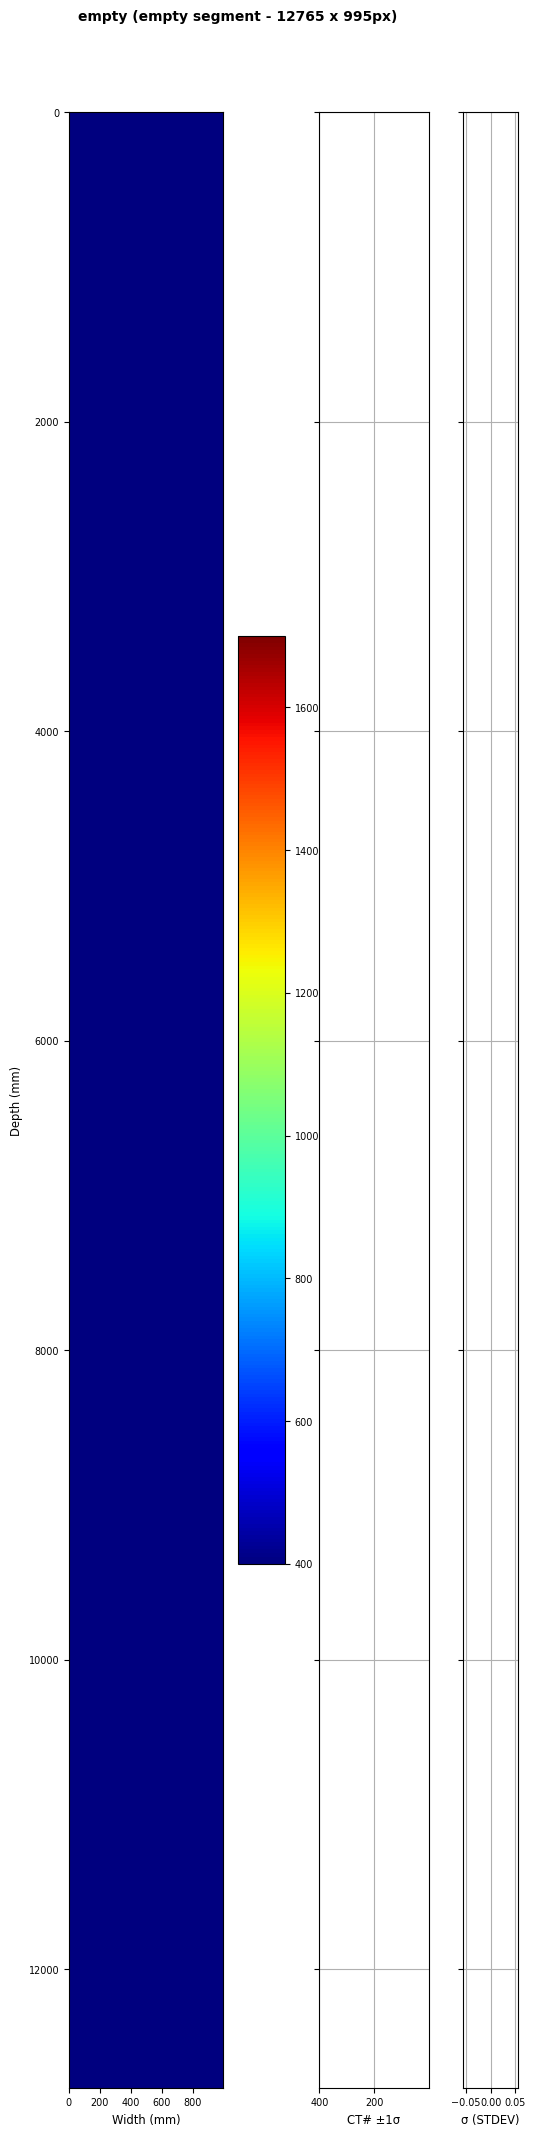

Processing TN0909-28JC-2


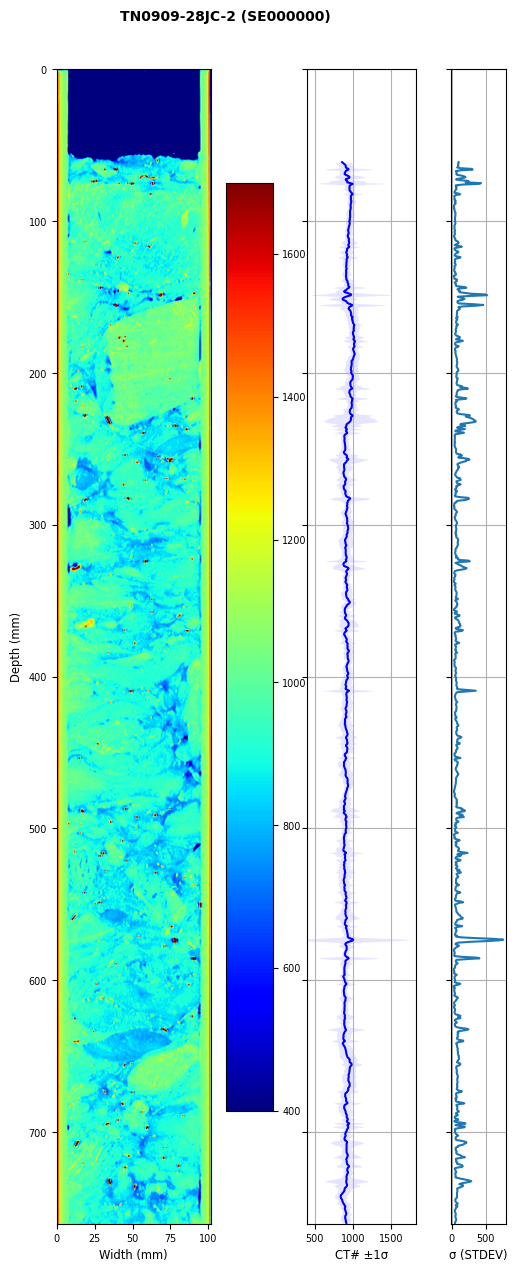

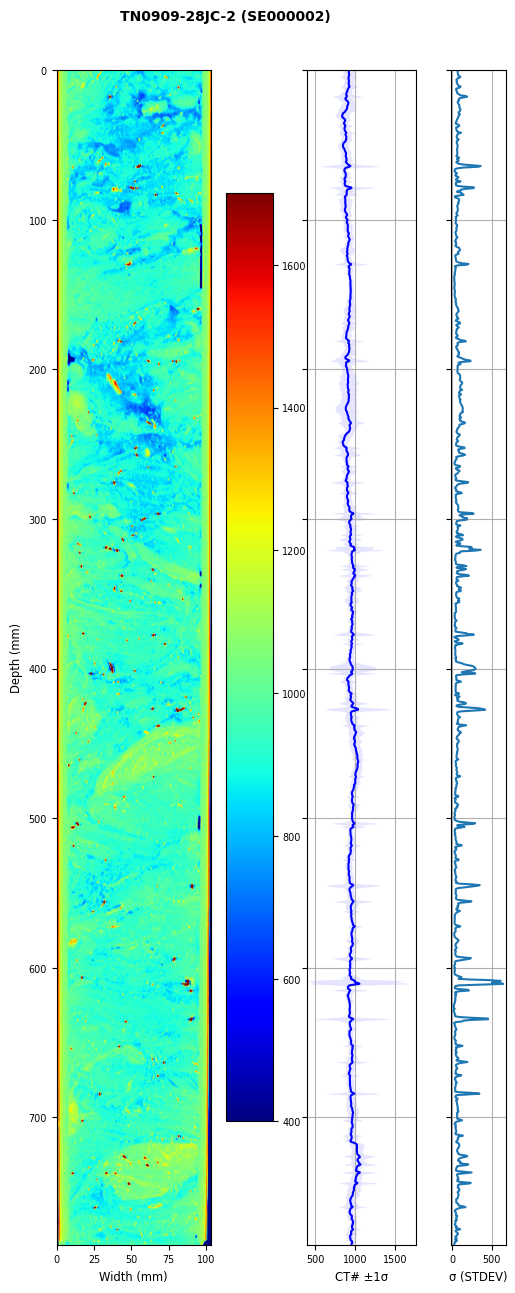

Brightness overlap: 211 pixels (correlation: 0.869)
Applied brightness shift: 26.822
Applied stddev shift: 11.890


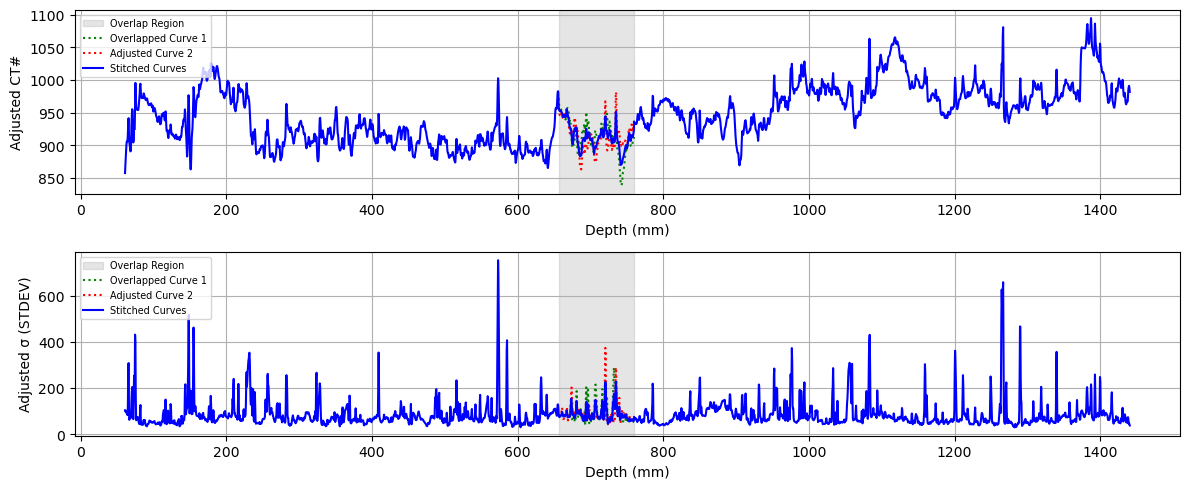

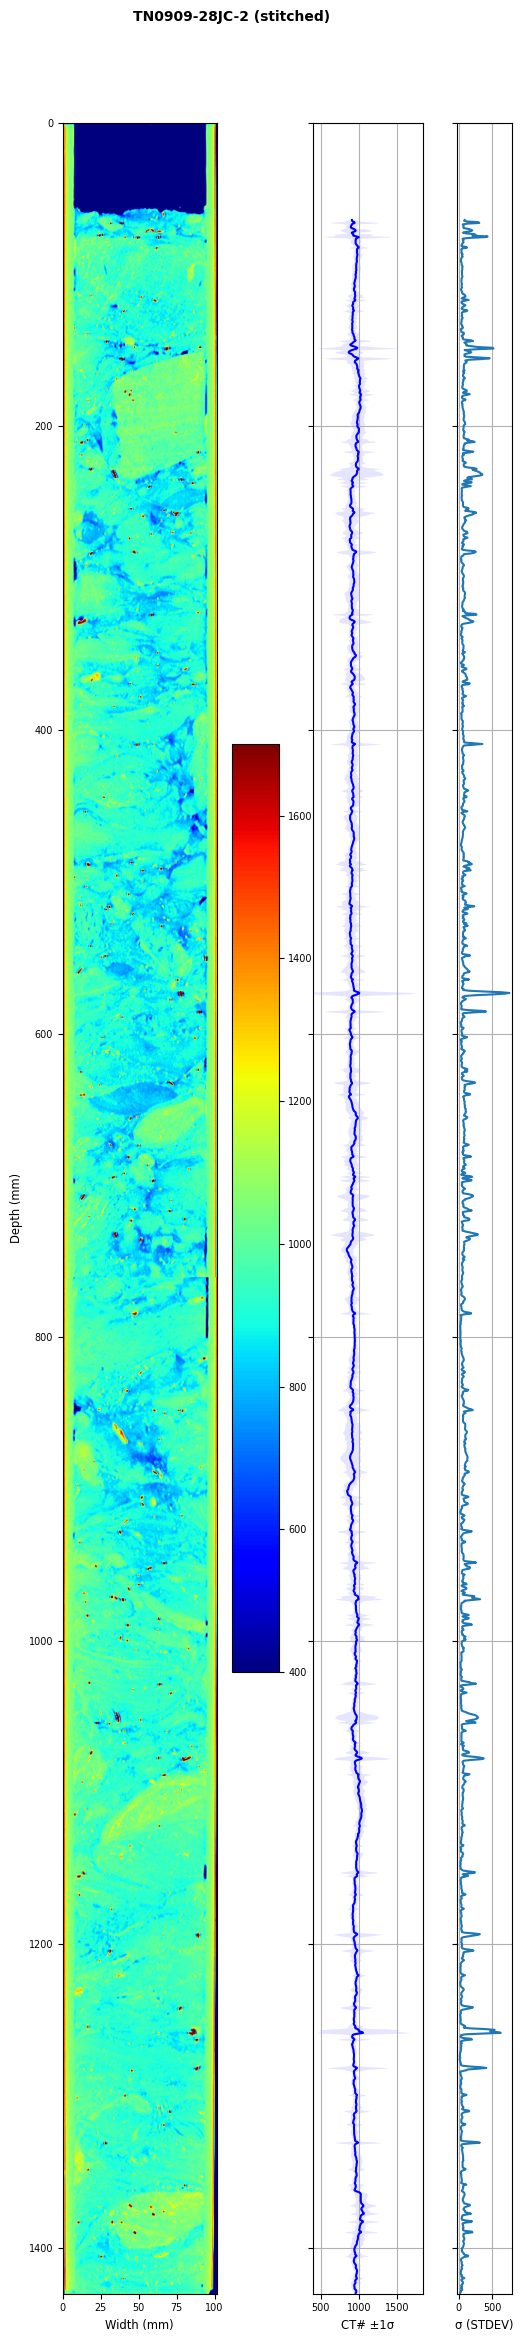

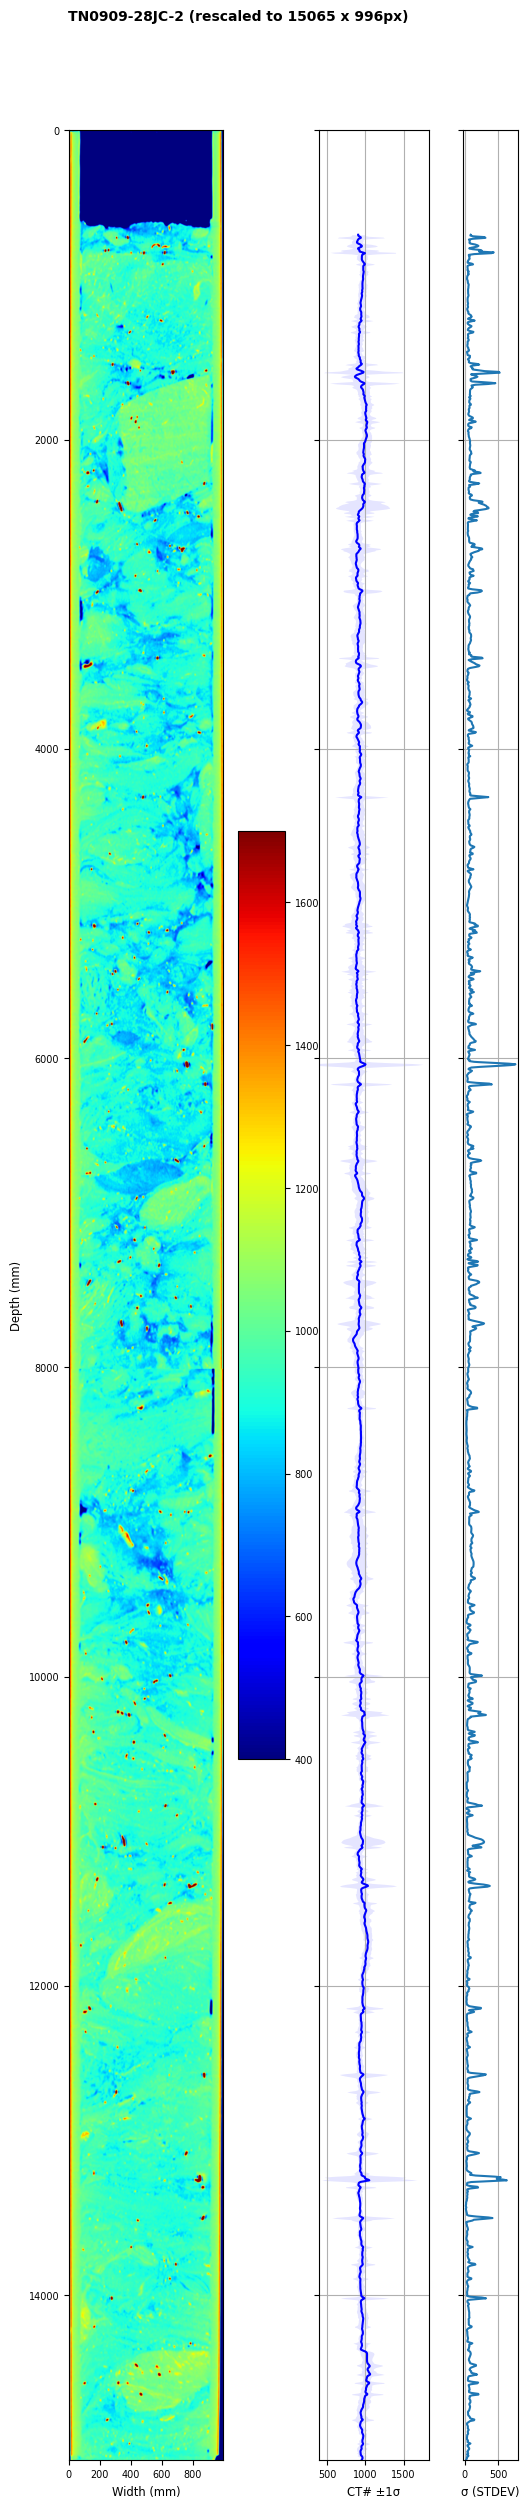

Processing TN0909-28JC-3


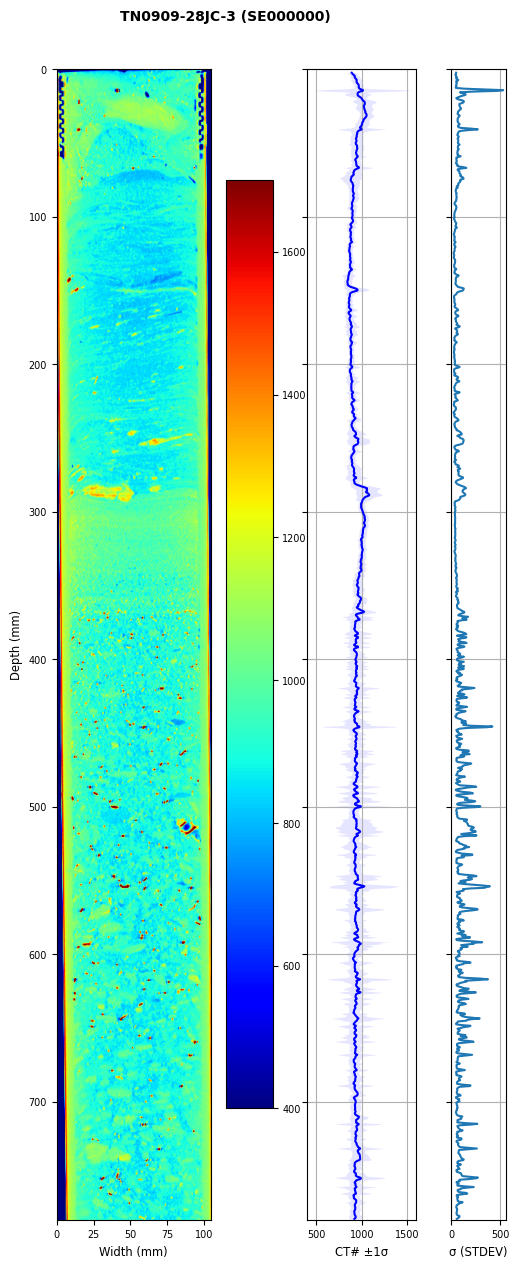

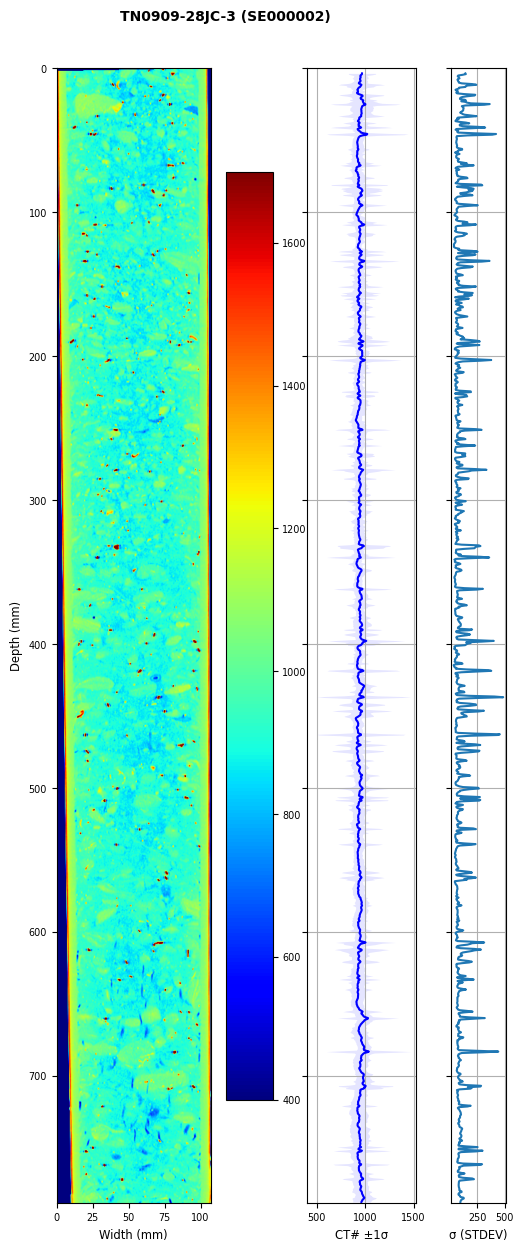

Brightness overlap: 151 pixels (correlation: 0.697)
Applied brightness shift: -1.909
Applied stddev shift: -17.526


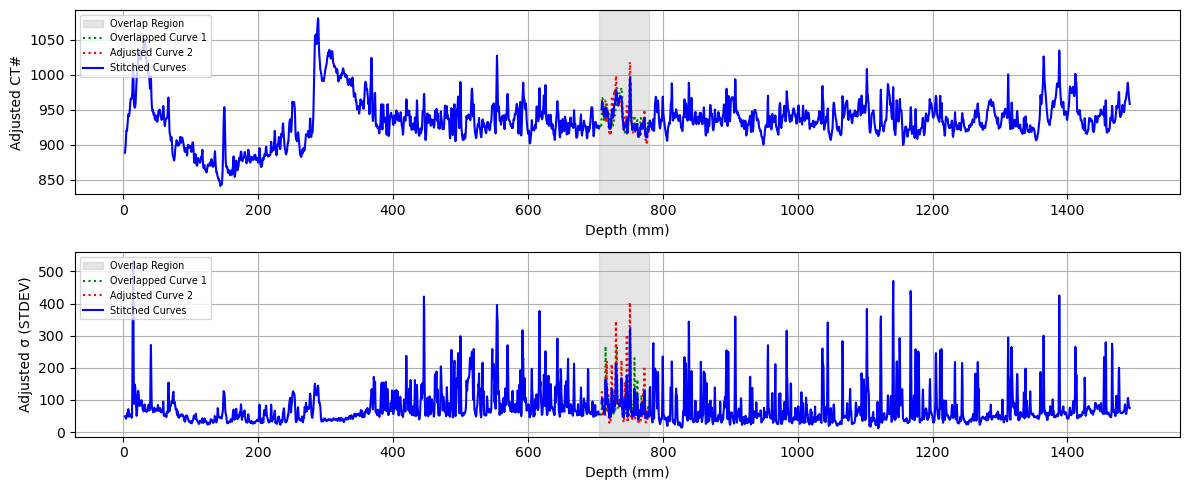

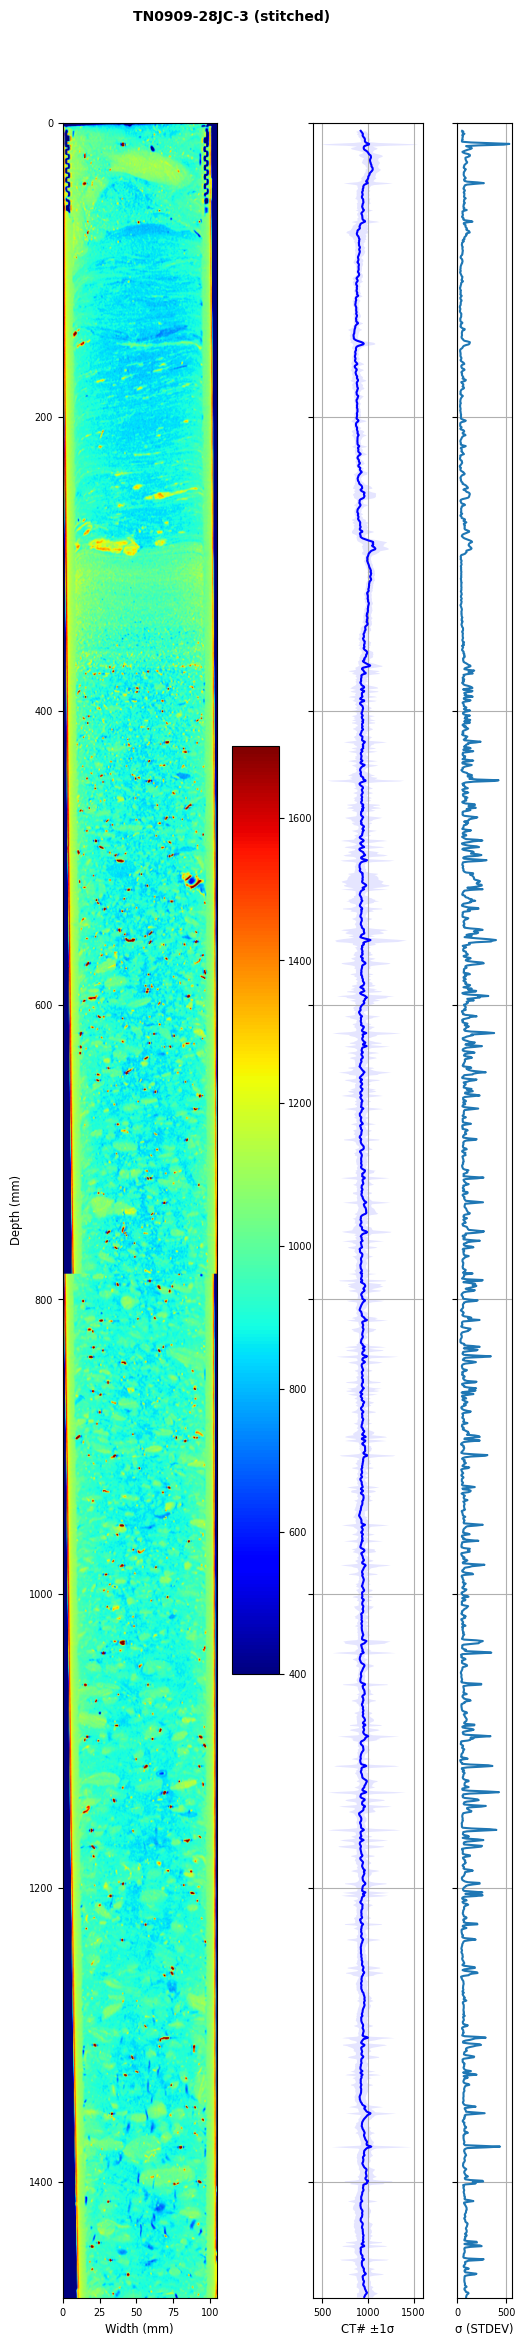

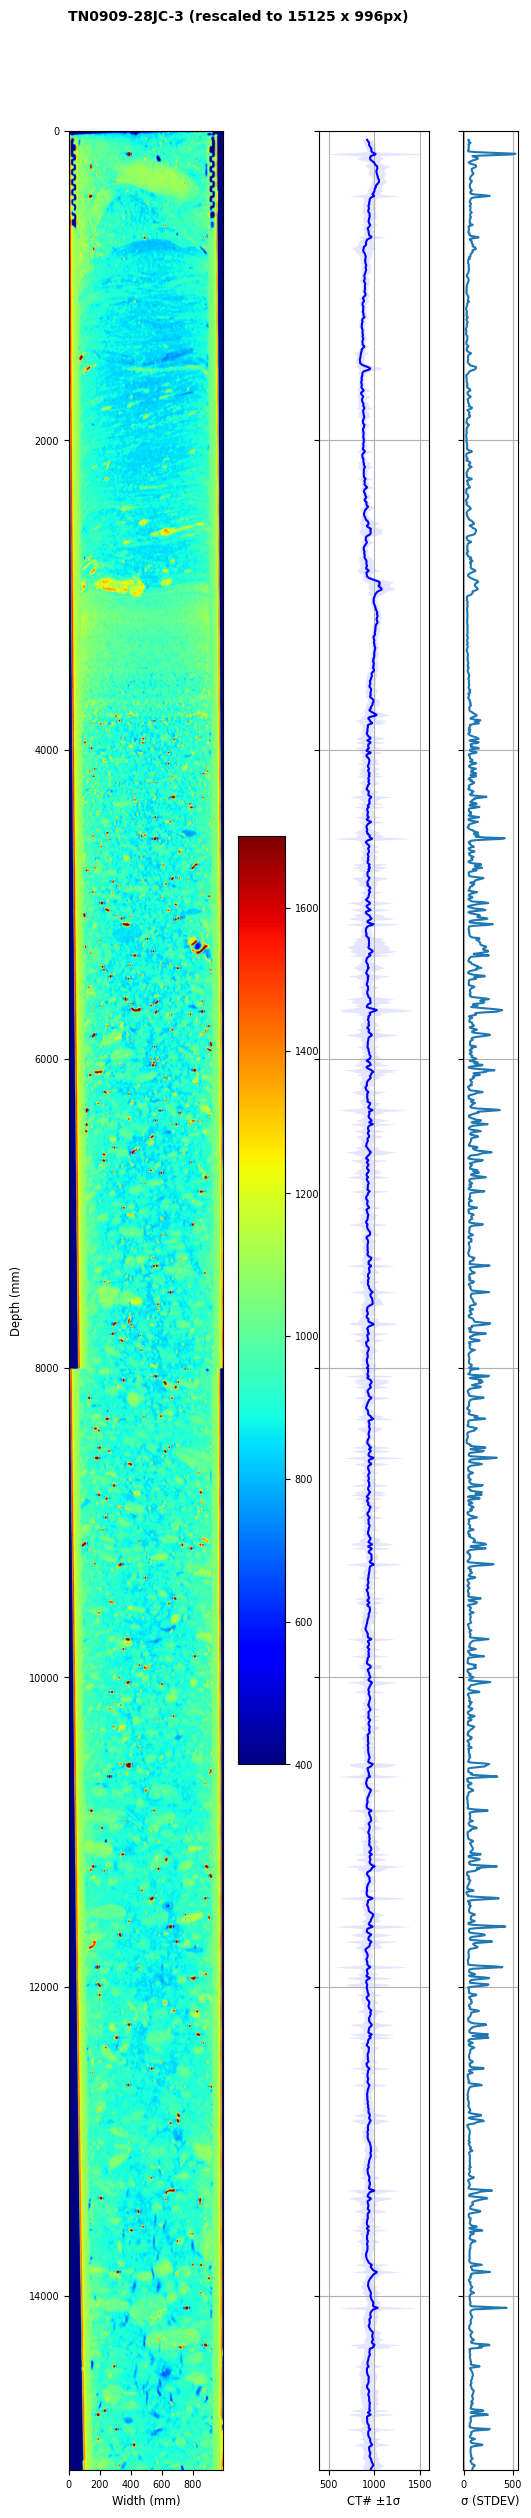

Processing TN0909-28JC-4


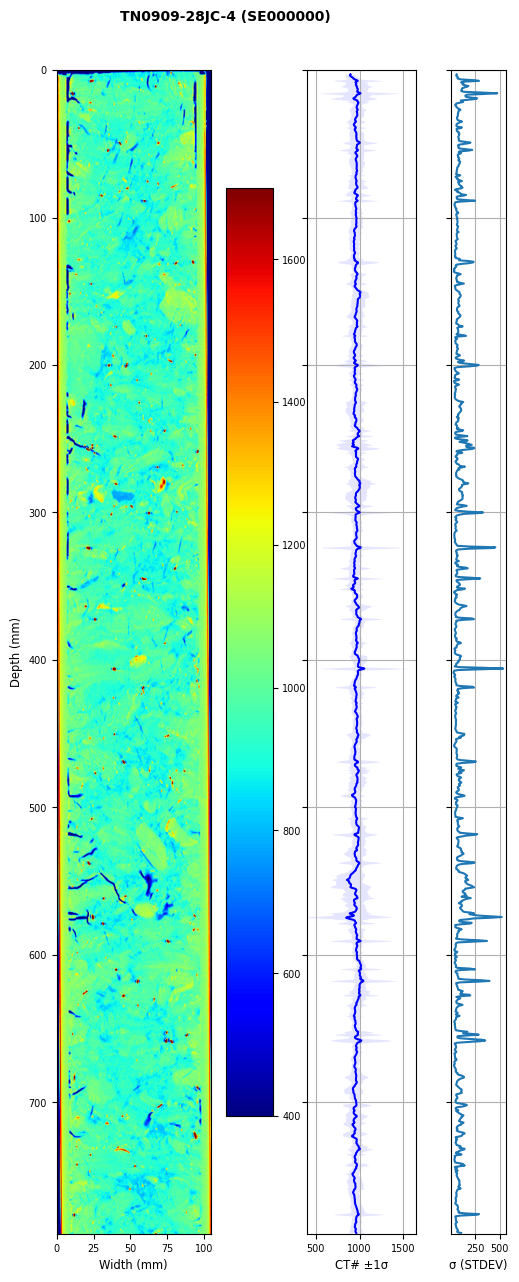

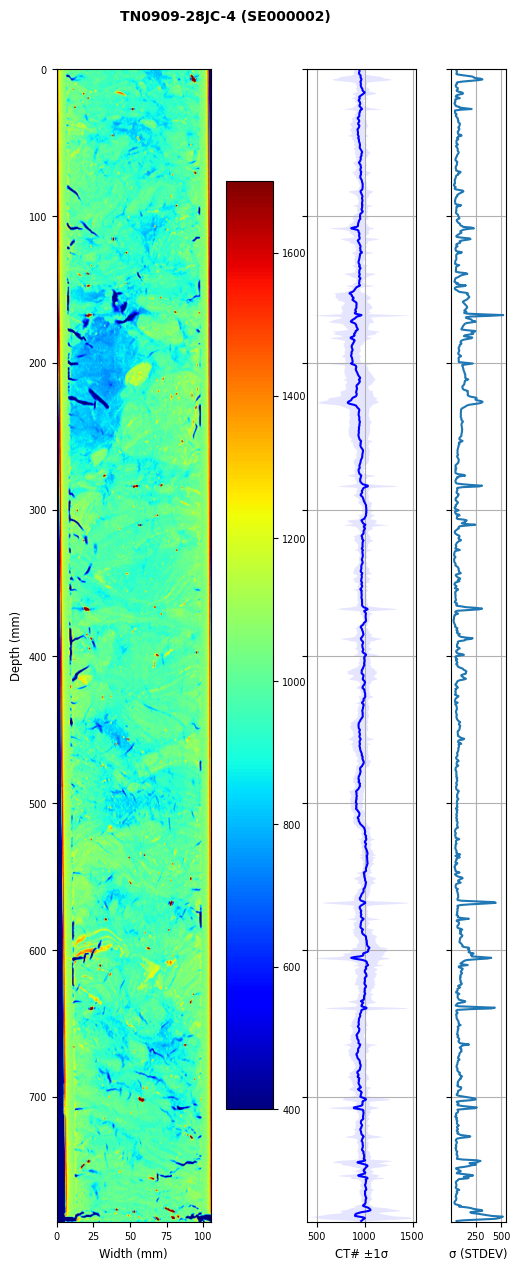

Brightness overlap: 59 pixels (correlation: 0.719)
Applied brightness shift: -4.070
Applied stddev shift: -21.209


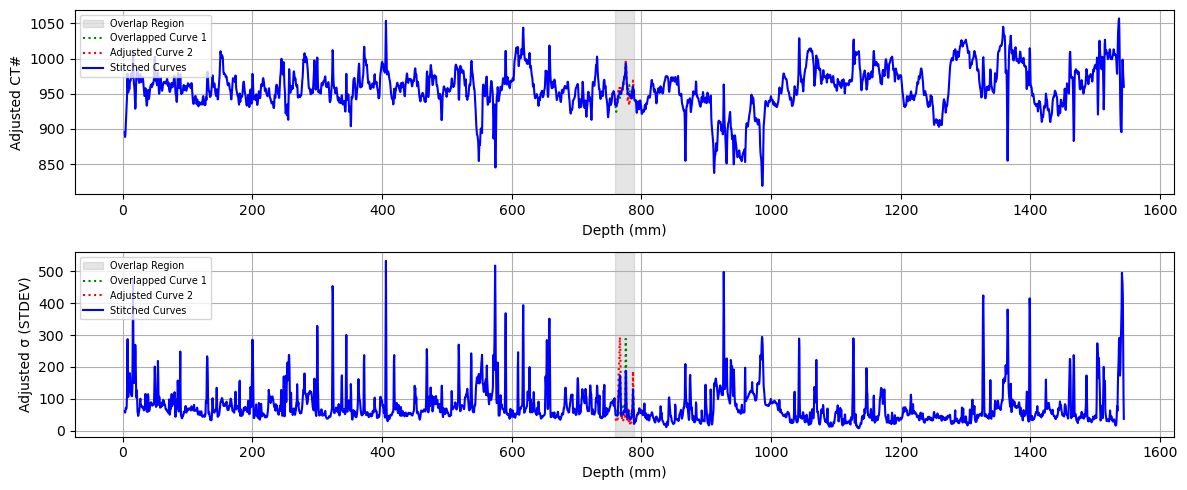

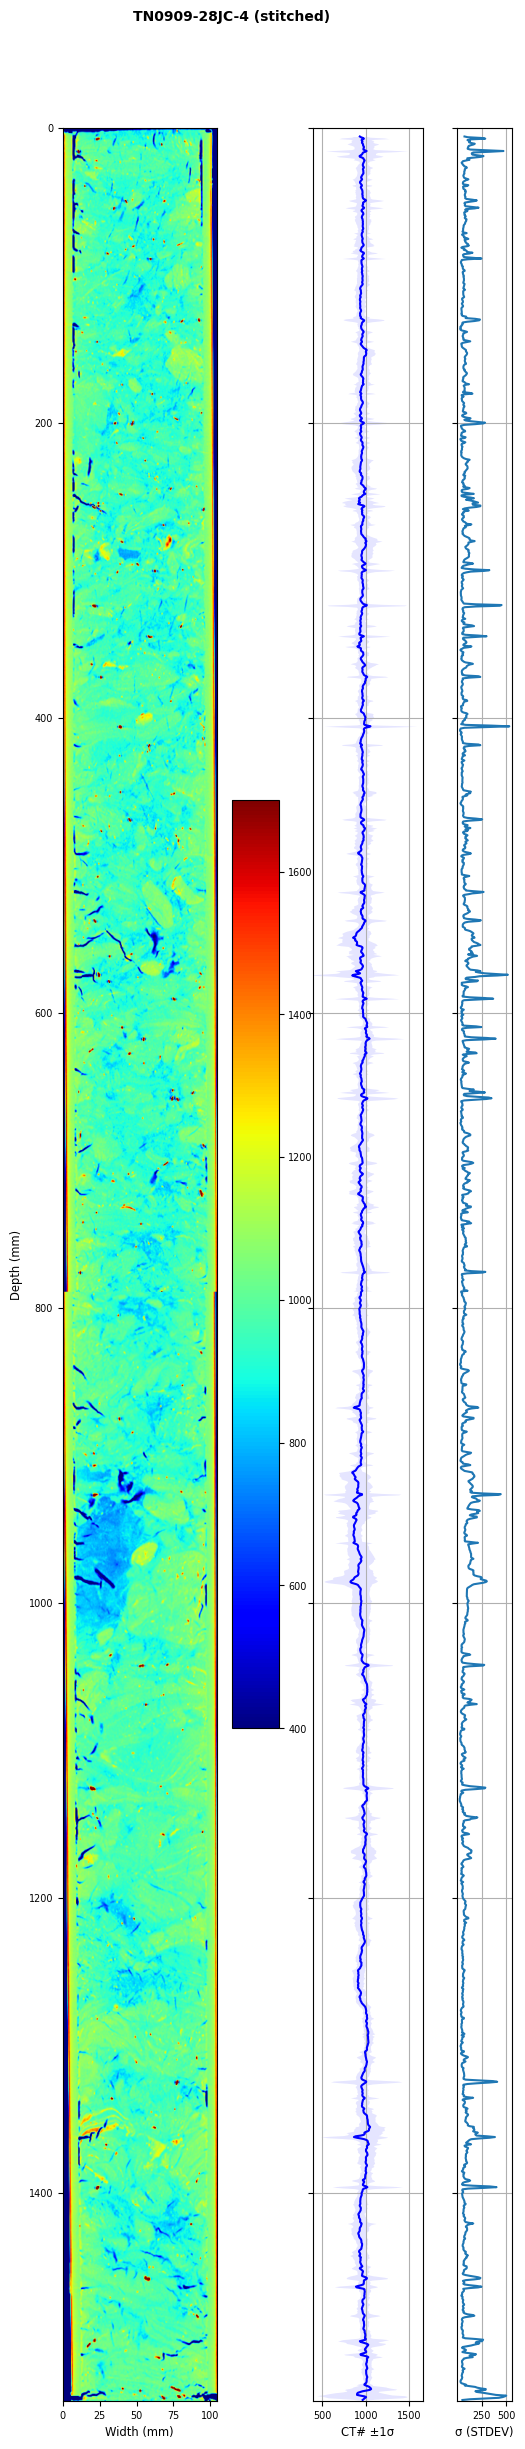

KeyboardInterrupt: 

In [56]:
# Process and stitch all segments
final_stitched_slice, final_stitched_brightness, final_stitched_stddev, final_stitched_depth, px_spacing_x, px_spacing_y = process_and_stitch_segments(
    core_structure,                         # Dictionary containing core segment configurations
    mother_dir,                             # Base directory path containing the CT scan data
    width_start_pct=width_start_pct,        # Starting percentage for width cropping
    width_end_pct=width_end_pct,            # Ending percentage for width cropping
    max_value_side_trim=1300,               # Maximum pixel value threshold for side trimming
    min_overlap=20,                         # Minimum overlap in pixels between segments
    max_overlap=300                         # Maximum overlap in pixels between segments
)


# Create csv output directory if it doesn't exist
output_dir_base = "/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/_compiled_logs"
stitched_core_folder = f"{cruise_name}-{core_name}"
output_dir = os.path.join(output_dir_base, stitched_core_folder)
os.makedirs(output_dir, exist_ok=True)

# Display & save final stitched results
display_slice_bt_std(final_stitched_slice,                       # Stitched CT slice data
                    final_stitched_brightness,                   # Stitched brightness values
                    final_stitched_stddev,                       # Stitched standard deviation values
                    pixel_spacing=(px_spacing_x, px_spacing_y),  # Pixel spacing in x and y directions
                    core_name=f"{cruise_name}-{core_name}_CT",   # Core identifier for display
                    save_figs = True,                            # Flag to save figures
                    output_dir = output_dir)                     # Directory to save output files

# Convert depth from pixels to cm
depth_cm = final_stitched_depth * (total_length_cm / final_stitched_depth[-1])

# Create DataFrame
df = pd.DataFrame({
    'SB_DEPTH_pxl': final_stitched_depth,    # Depth values in pixels
    'SB_DEPTH_cm': depth_cm,                 # Depth values in centimeters
    'CT': final_stitched_brightness,         # CT brightness/density values
    'CT_std': final_stitched_stddev          # CT standard deviation values
})

# Save stitched data into CSV
output_file = os.path.join(output_dir, f'{cruise_name}-{core_name}_CT.csv')
df.to_csv(output_file, index=False)
print(f"CT data saved to: ~/{'/'.join(output_file.split('/')[-3:])}")